# Single Cell analisys of Mus musculus limb muscle tissue

Data obtained from: https://datasets.cellxgene.cziscience.com/8efaf5ba-9121-451a-a4d4-d63add2404d8.h5ad

### Import necessary libraries

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
from scipy.io import mmread
import scipy.io as scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

### Load data into an AnnData object

In [2]:
adata = sc.read('limbmuscle_sc.h5ad')  # Read the reduced AnnData 
adata.var_names_make_unique()
adata.var_names = adata.var_names.astype(str)  # Convert to string if categorical

In [3]:
adata.var_names = adata.var['feature_name']

/home/albert-turon/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:844: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Rsrc2', 'Tmem121', 'Ube3b', 'Rnf167', 'Snx13']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [4]:
adata.obs['age']= adata.obs['age'].astype('category')

## Quality Control
### Calculate percentage of mitochondrial genes to check quality of our data

In [5]:
# mitochondrial genes start with "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("Mt")

In [6]:
#Calculates metrics such as total_counts, nº of genes by counts and % of mitochondrial counts
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)


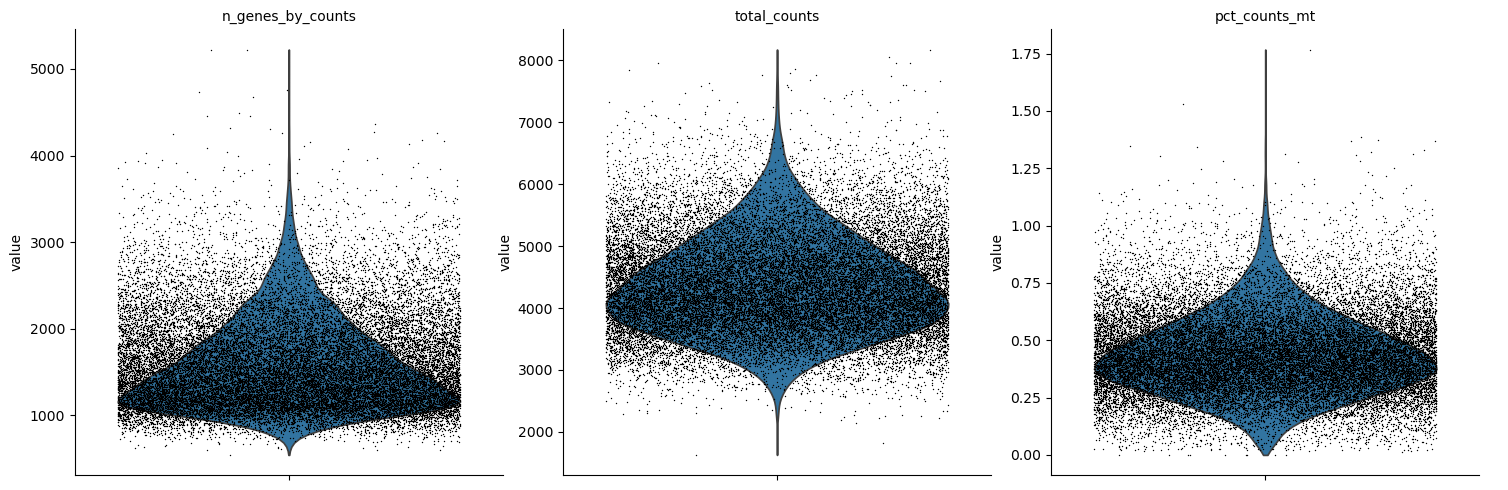

In [7]:
# Violin plots to visualize the quality of our data
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

By observing this plots we can say that our data has a high quality as the majority of cells have more than 3000 counts and there arent many high count cells which would indicate the presence of doublets. Moreover, we can see there is an average of more than 1000 genes by count.

The average percentage of mitochondrial gene counts is well below 1% indicating that our data doesn't contain many damaged cells and has a high quality.

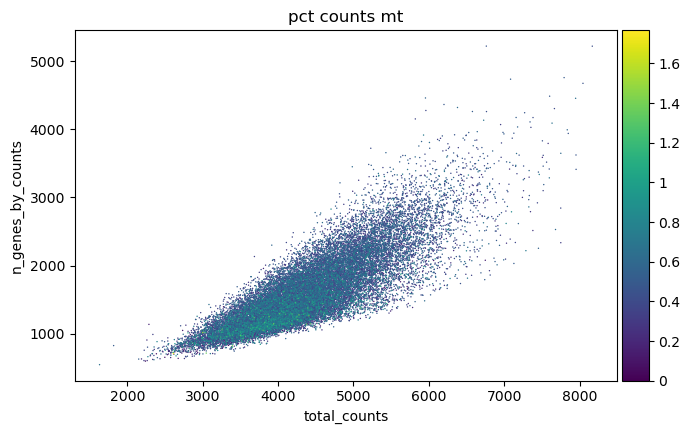

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Filtering

If our data has low quality we can filter cells that have a high percentage of mithocondrial gene counts, cells that have a low number of genes and/or genes that are only expressed in a few cells.

In our case the quality of our data is quite high so it is not really necessary to perform this step

In [9]:
sc.pp.filter_cells(adata, min_genes=100) # filters cells that have a low number of counts (expressed genes)
sc.pp.filter_genes(adata, min_cells=10) # filters genes that are expressed in less than 10 cells

We can further filter our data by using a scanpy function to detect and remove doublets

In [10]:
sc.pp.scrublet(adata, batch_key="age", n_prin_comps=25)

## Clustering

We save the raw data in a layer of the AnnData object named "counts". This way we can transform the data without risk of losing our original data.

In [11]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

### Transforming our data and calculating PCs
We normalize our data and calculate the highly variable genes to be able to clusterize our cells later on

In [12]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [13]:
adata.obs["age"] = adata.obs["age"].astype("category") # Transform age column into a category to use it as groups
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="age") # Calculate the highly variable genes

In [14]:
# We can check if the gene we are interested in is highly variable
if 'Myod1' in adata.var_names:
    is_highly_variable = adata.var.loc['Myod1', 'highly_variable']
    print(f"Is Myod1 highly variable? {is_highly_variable}")

Is Myod1 highly variable? False


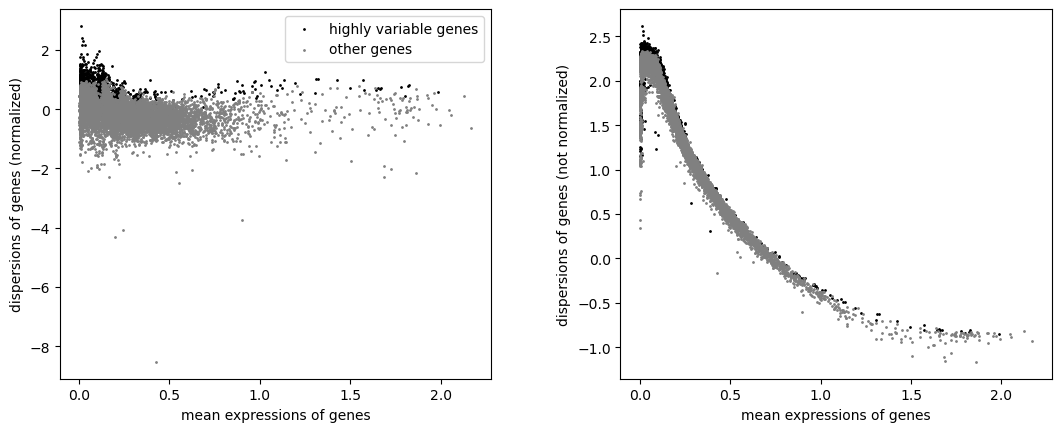

In [15]:
# Elbow graphs showing the distributions of the highly variable genes
sc.pl.highly_variable_genes(adata)

We perform a principal component analisys (pca) to reduce the dimensionality of our data while preserving the most significant sources of variance.

In [16]:
sc.tl.pca(adata)

We can plot the variance ratio of each principal component (pc) to better understand how much variance is described by each pc.

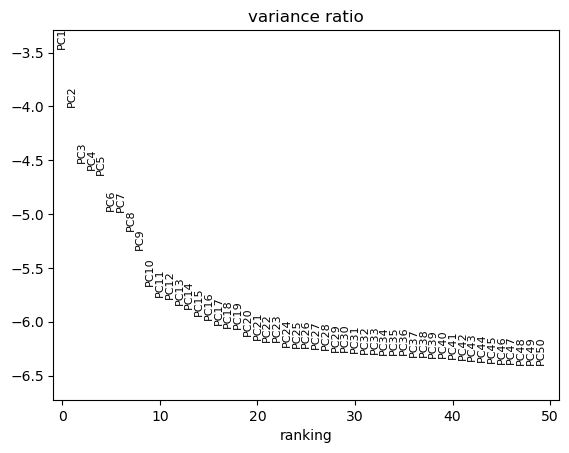

In [17]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### Calculating neighbors and clustering the data

In [18]:
sc.pp.neighbors(adata)

In [19]:
sc.tl.umap(adata)

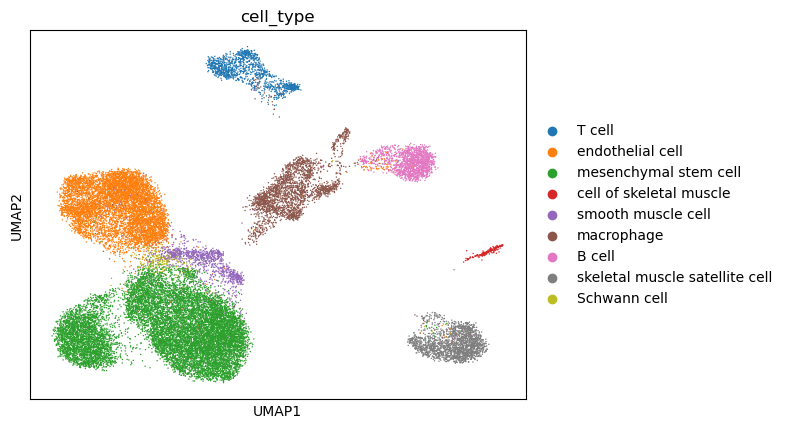

In [20]:
sc.pl.umap(
    adata,
    color="cell_type",
)

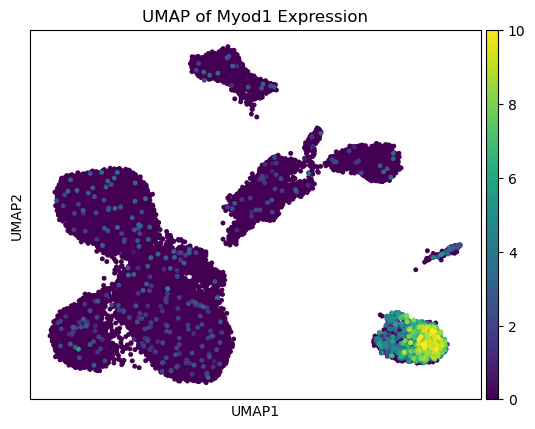

In [21]:
# Extract the expression values of 'Myod1' from the 'counts' layer
myod1_counts = adata.layers["counts"][:, adata.var_names.get_loc("Myod1")].toarray().flatten()

# Add Myod1 expression from raw counts to adata.obs for plotting
adata.obs["Myod1_raw"] = myod1_counts

# Plot UMAP with Myod1 expression from raw counts
sc.pl.umap(
    adata, 
    color="Myod1_raw",
    size=50,
    vmin=0,
    vmax=10,
    title="UMAP of Myod1 Expression"
)


### Analyzing gene expression by age

In [29]:
# Ensuring the age groups are categories and ordering them
adata.obs['age'] = pd.Categorical(
    adata.obs['age'], 
    categories=['1m', '3m', '18m', '21m', '24m', '30m'], # Replace with your specific age groups
    ordered=True
)

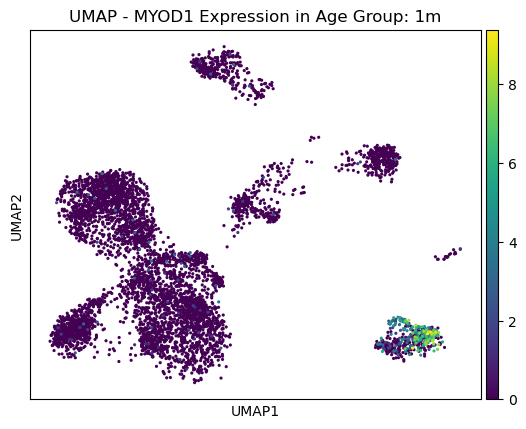

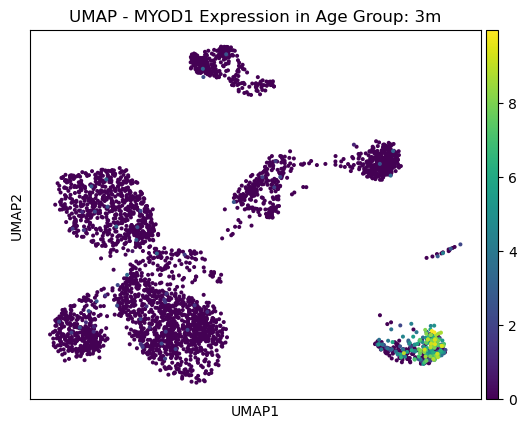

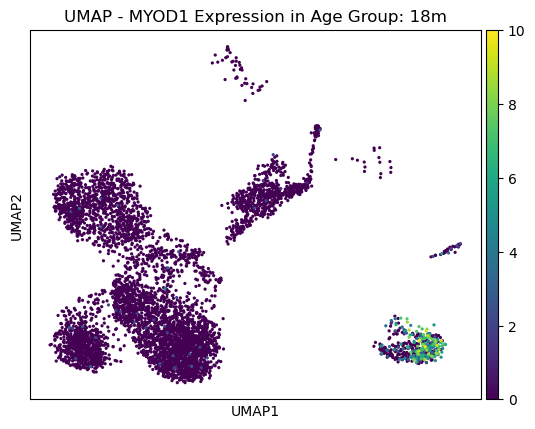

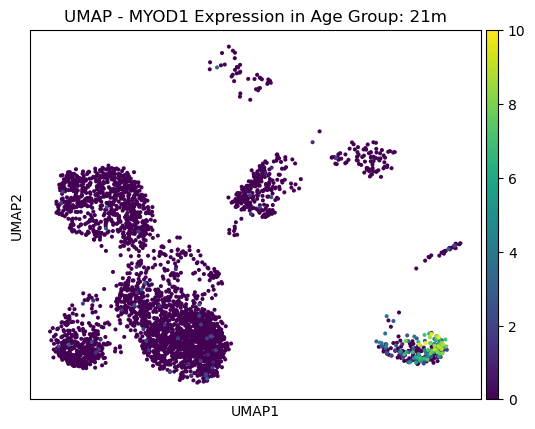

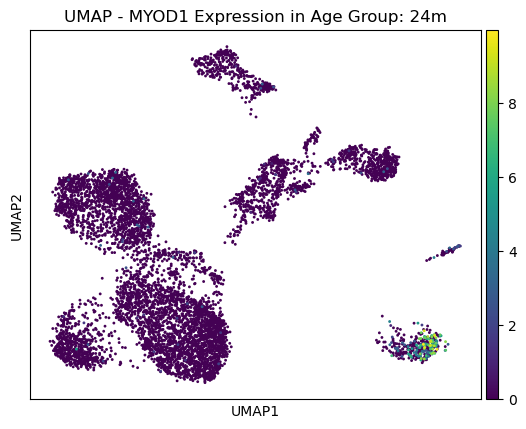

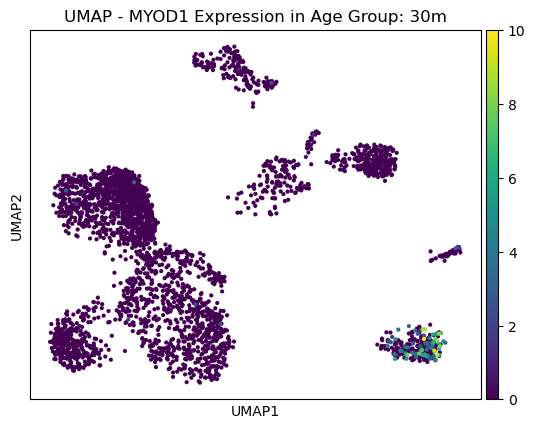

In [31]:
age_groups = adata.obs['age'].cat.categories

# Plot UMAP for each age group with MYOD1 expression
for group in age_groups:
    # Subset data for the current age group
    adata_subset = adata[adata.obs['age'] == group]
    sc.pl.umap(
        adata_subset,  # Make sure to use the subset here
        color='Myod1_raw', 
        title=f'UMAP - MYOD1 Expression in Age Group: {group}', 
        vmin=0, vmax=None, 
        cmap='viridis',
        show=True
    )


In [32]:
# Subseting only skeletal muscle satellite cells from data
satellite_cells = adata[adata.obs['cell_type'] == 'skeletal muscle satellite cell']

myod1_expression = satellite_cells[:, 'Myod1'].X.toarray().flatten() 
age_groups = satellite_cells.obs['age'].values

In [34]:
data = pd.DataFrame({
    'MYOD1_expression': myod1_expression,
    'Age_group': age_groups
})

In [35]:
from scipy.stats import kruskal

# Group MYOD1 expression data by age group
groups = [data[data['Age_group'] == age]['MYOD1_expression'].values for age in data['Age_group'].unique()]

# Perform Kruskal-Wallis test
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis p-value: {kruskal_result.pvalue:.3f}")

Kruskal-Wallis p-value: 0.000
Significant differences in MYOD1 expression among age groups.


In [36]:
# Perform Dunn's test with Bonferroni correction for multiple comparisons
dunn_results = sp.posthoc_dunn(
    data, 
    val_col='MYOD1_expression', 
    group_col='Age_group', 
    p_adjust='bonferroni'
)

# Display the results
print("Pairwise Dunn's Test Results (adjusted p-values):")
print(dunn_results)

Pairwise Dunn's Test Results (adjusted p-values):
           1m        3m       18m       21m       24m       30m
1m   1.000000  0.000700  0.022966  0.052887  1.000000  1.000000
3m   0.000700  1.000000  1.000000  1.000000  0.001689  0.000114
18m  0.022966  1.000000  1.000000  1.000000  0.038904  0.002736
21m  0.052887  1.000000  1.000000  1.000000  0.067186  0.005715
24m  1.000000  0.001689  0.038904  0.067186  1.000000  1.000000
30m  1.000000  0.000114  0.002736  0.005715  1.000000  1.000000


/home/albert-turon/anaconda3/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:368: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/home/albert-turon/anaconda3/lib/python3.12/site-packages/scikit_posthocs/_posthocs.py:371: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)["ranks"].mean()


/tmp/ipykernel_15840/2769968343.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x='Age_group', y='MYOD1_expression', inner='quartile', palette='Set3')


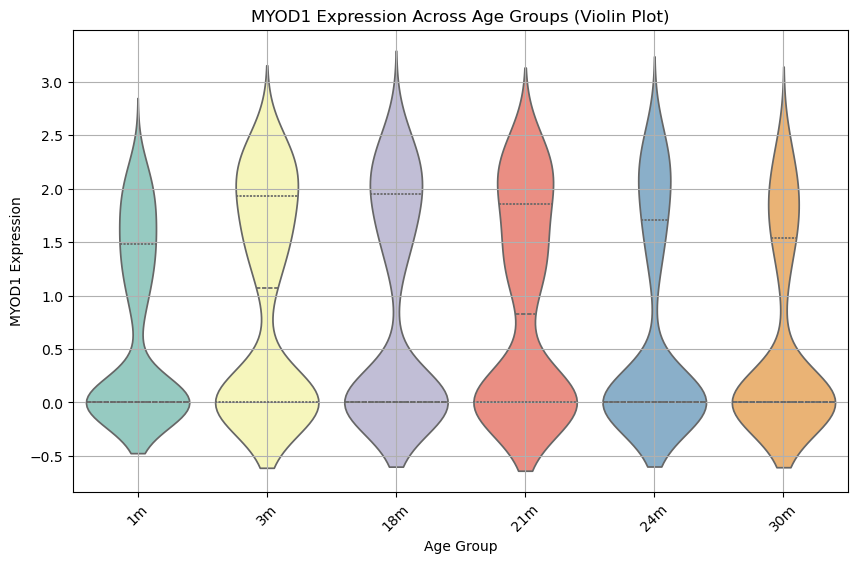

In [37]:
# Create a violin plot to visualize the distribution of MYOD1 expression
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='Age_group', y='MYOD1_expression', inner='quartile', palette='Set3')
plt.title('MYOD1 Expression Across Age Groups (Violin Plot)')
plt.xlabel('Age Group')
plt.ylabel('MYOD1 Expression')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()